
## What changed between DINOV2 and DINOV3

**Context.** PCA over patch embeddings often highlights background/foreground contrasts and local textures. How smooth those PCA maps look depends on the **spatial coherence** of the underlying features.

**What changed with DINOv3?** Compared to DINOv2, DINOv3 training emphasizes stability of **dense (patch-level) representations**—so neighboring patches receive more consistent embeddings. When PCA projects these features, values vary **continuously** across the grid, producing smoother maps and cleaner object/background separations.


In [1]:
# [STEP] Imports
# Shared libraries for feature extraction, numerics, and plotting.
import os
from pathlib import Path

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from sklearn.decomposition import PCA
from torchvision import transforms
import matplotlib.pyplot as plt
from transformers import pipeline

torch.set_grad_enabled(False)
device = torch.device('cpu')



## DINOv3 produces more **global** and less **local-noise** embeddings

**Key idea.** DINOv3 learns features that prioritize large-scale structure (shape, silhouette, layout) over micro-texture fluctuations. This makes nearby patches in an object share similar representations and reduces sensitivity to small local changes (color noise, tiny textures).

**Implication for PCA.**
PCA: leading components reflect macro contrasts (object vs. background) rather than high-frequency background artifacts.


In [2]:
# [STEP] Load DINO models (v2 & v3)
# Both backbones are loaded once so every downstream visualisation can reuse them.
MODEL_SPECS = [
    {"name": "DINOv2", "model_id": "facebook/dinov2-base", "input_size": 518},
    {"name": "DINOv3", "model_id": "facebook/dinov3-vitb16-pretrain-lvd1689m", "input_size": 512},
]

MODEL_ORDER = [spec["name"] for spec in MODEL_SPECS]
model_registry = {}

for spec in MODEL_SPECS:
    print(f"Loading {spec['name']} from {spec['model_id']}...")
    feature_pipe = pipeline("image-feature-extraction", model=spec["model_id"])
    model = feature_pipe.model.to(device)
    model.eval()

    patch_size = model.config.patch_size
    hidden_size = model.config.hidden_size
    special_tokens = 1 + getattr(model.config, 'num_register_tokens', 0) + getattr(model.config, 'num_global_tokens', 0)

    transform = transforms.Compose([
        transforms.Resize(spec["input_size"]),
        transforms.CenterCrop(spec["input_size"]),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.2),
    ])

    display_transform = transforms.Compose([
        transforms.Resize(spec["input_size"]),
        transforms.CenterCrop(spec["input_size"]),
    ])

    model_registry[spec["name"]] = {
        "model": model,
        "transform": transform,
        "display_transform": display_transform,
        "patch_size": patch_size,
        "hidden_size": hidden_size,
        "special_tokens": special_tokens,
        "input_size": spec["input_size"],
        "model_id": spec["model_id"],
    }

    del feature_pipe  # free tokenizer/processor we do not reuse

model_summary = {name: {k: info[k] for k in ("patch_size", "hidden_size", "input_size")}
                 for name, info in model_registry.items()}
print('Model summary:', model_summary)


Loading DINOv2 from facebook/dinov2-base...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use mps:0


Loading DINOv3 from facebook/dinov3-vitb16-pretrain-lvd1689m...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use mps:0


Model summary: {'DINOv2': {'patch_size': 14, 'hidden_size': 768, 'input_size': 518}, 'DINOv3': {'patch_size': 16, 'hidden_size': 768, 'input_size': 512}}


In [3]:
# [STEP] Extract patch grids for both models
# Each model produces an (image, H, W, D) tensor we reuse across visualisations.
folder_path = Path('leopard')
valid_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
image_paths = sorted(p for p in folder_path.glob('*') if p.suffix.lower() in valid_exts)
if not image_paths:
    raise RuntimeError(f'No images found in {folder_path.resolve()} with extensions {sorted(valid_exts)}')

IMAGE_NAMES = [p.name for p in image_paths]
RAW_IMAGES = [Image.open(p).convert('RGB') for p in image_paths]

feature_store = {}

with torch.no_grad():
    for name in MODEL_ORDER:
        cfg = model_registry[name]
        print(f'Extracting patch tokens for {name} ({cfg["model_id"]})')
        patch_tokens = []
        display_images = []
        for img in RAW_IMAGES:
            input_tensor = cfg['transform'](img).unsqueeze(0)
            outputs = cfg['model'](input_tensor)
            tokens = outputs.last_hidden_state[:, cfg['special_tokens']:, :]
            tokens = F.normalize(tokens, dim=-1)
            patch_tokens.append(tokens.cpu())
            display_images.append(cfg['display_transform'](img))

        patches = torch.cat(patch_tokens, dim=0)
        num_patches = patches.shape[1]
        patch_h = cfg['input_size'] // cfg['patch_size']
        patch_w = num_patches // patch_h
        if patch_h * patch_w != num_patches:
            raise ValueError(f"Unexpected token grid for {name}: got {num_patches} tokens vs {patch_h}x{patch_w}")

        patch_features = patches.reshape(len(IMAGE_NAMES), patch_h, patch_w, cfg['hidden_size']).contiguous()

        feature_store[name] = {
            'patch_features': patch_features,
            'patch_h': patch_h,
            'patch_w': patch_w,
            'hidden_size': cfg['hidden_size'],
            'display_images': display_images,
        }

print({name: feature_store[name]['patch_features'].shape for name in MODEL_ORDER})


Extracting patch tokens for DINOv2 (facebook/dinov2-base)
Extracting patch tokens for DINOv3 (facebook/dinov3-vitb16-pretrain-lvd1689m)
{'DINOv2': torch.Size([6, 37, 37, 768]), 'DINOv3': torch.Size([6, 32, 32, 768])}


In [4]:
# [STEP] PCA decomposition per model
# Fit PCA on patch embeddings from each model independently (3 leading components).
pca_store = {}
for name in MODEL_ORDER:
    data = feature_store[name]
    flat = data['patch_features'].reshape(-1, data['hidden_size'])
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(flat.numpy())
    pcs_cube = pcs.reshape(len(IMAGE_NAMES), data['patch_h'], data['patch_w'], 3)
    pca_store[name] = {
        'pca': pca,
        'components': pcs_cube,
    }

print({name: pca_store[name]['components'].shape for name in MODEL_ORDER})


{'DINOv2': (6, 37, 37, 3), 'DINOv3': (6, 32, 32, 3)}


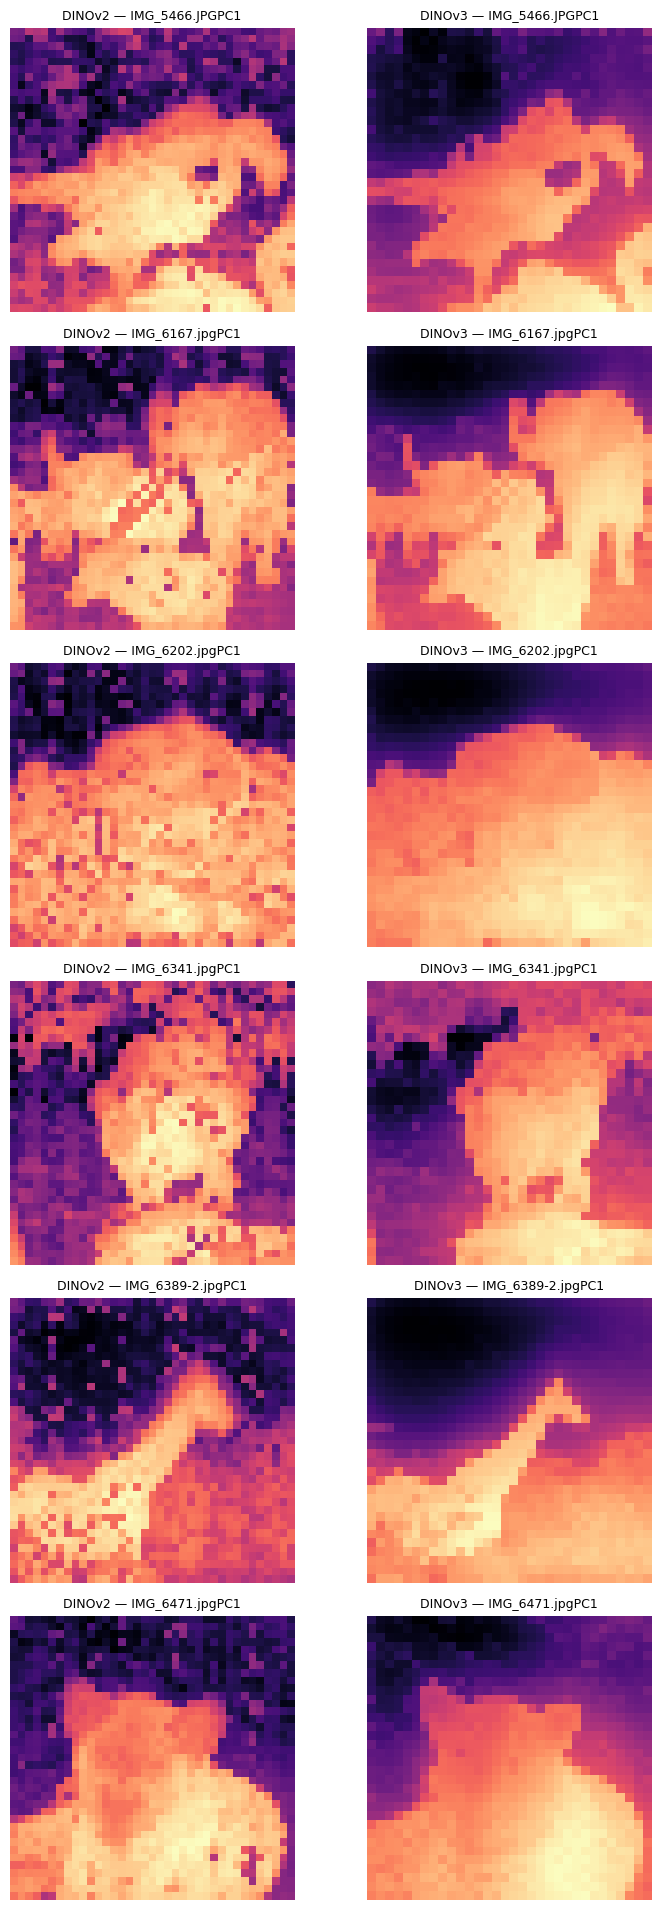

In [ ]:
# [STEP] Visual helper for PCA maps
# Displays DINOv2 (left) vs DINOv3 (right) for a given principal component.
def show_pca_component(component_idx=0, cmap='magma'):
    rows = len(IMAGE_NAMES)
    cols = len(MODEL_ORDER)
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.2 * rows))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    for row_idx, image_name in enumerate(IMAGE_NAMES):
        for col_idx, model_name in enumerate(MODEL_ORDER):
            ax = axes[row_idx, col_idx]
            comp = pca_store[model_name]['components'][row_idx, :, :, component_idx]
            comp_min, comp_max = comp.min(), comp.max()
            if comp_max - comp_min > 1e-6:
                comp_norm = (comp - comp_min) / (comp_max - comp_min)
            else:
                comp_norm = np.zeros_like(comp)
            ax.imshow(comp_norm, cmap=cmap, vmin=0.0, vmax=1.0)
            ax.set_title(f"{model_name} — {image_name}PC{component_idx + 1}", fontsize=9)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example: first principal component
show_pca_component(component_idx=0)


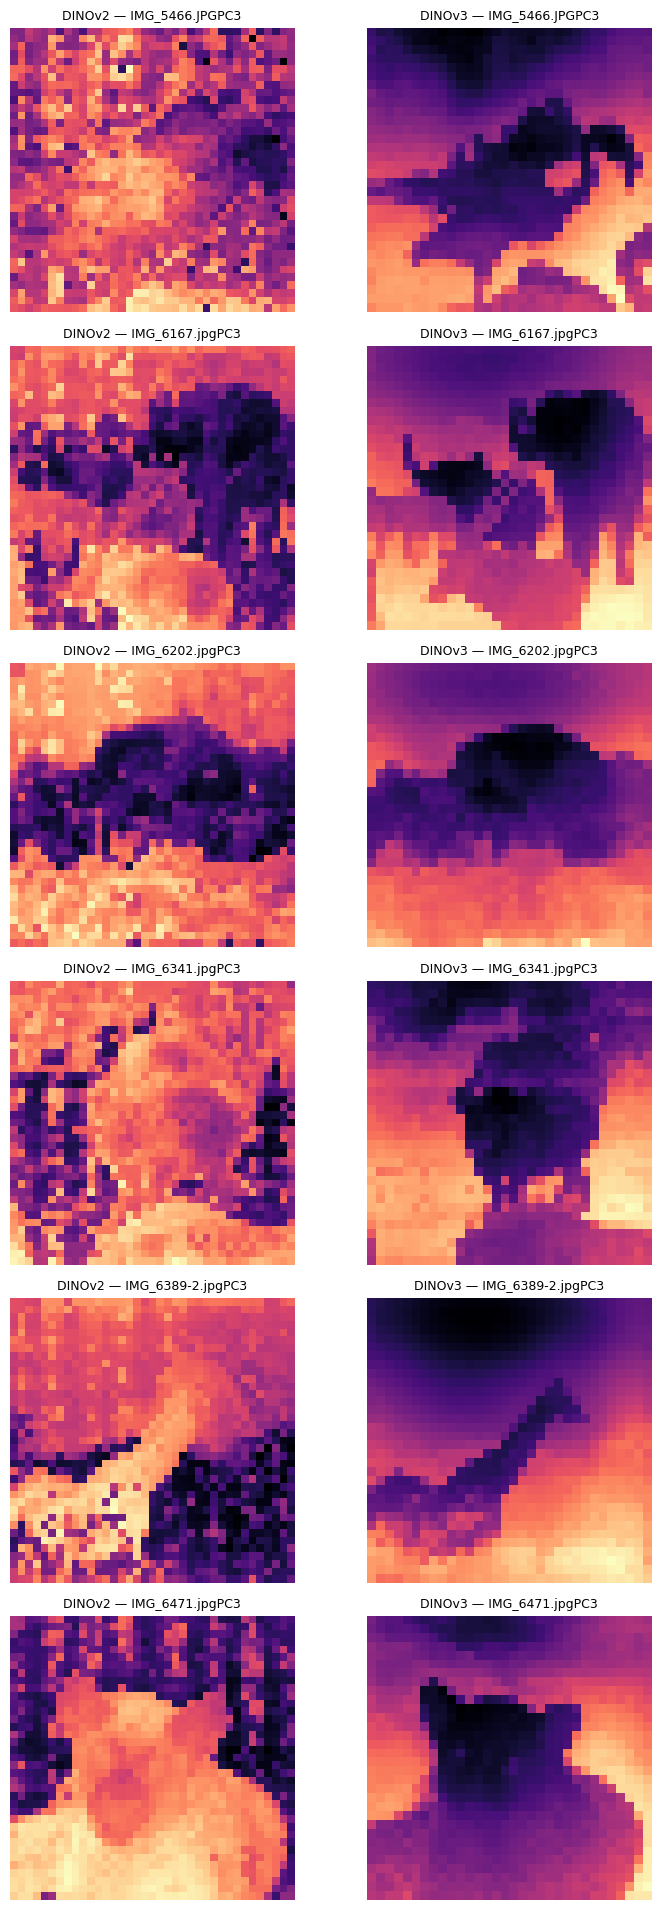

In [16]:
show_pca_component(component_idx=2)


In [10]:
# [STEP] Cosine similarity maps (raw patch space)
# Shared helper that returns a normalised similarity grid for a chosen patch.
def cosine_similarity_map_raw(patch_tensor: torch.Tensor, query_patch=None):
    """Return a 2-D cosine similarity map for a single image.

    Args:
        patch_tensor: (H, W, D) tensor of normalised patch features.
        query_patch: optional (row, col) reference patch. Defaults to grid centre.
    Returns:
        sim_map: numpy array (H, W) scaled to [0, 1].
        query_patch: actual (row, col) used.
    """
    if patch_tensor.ndim != 3:
        raise ValueError('patch_tensor must be 3-D (H, W, D).')

    h, w, d = patch_tensor.shape
    if query_patch is None:
        query_patch = (h // 2, w // 2)

    q_row, q_col = query_patch
    if not (0 <= q_row < h and 0 <= q_col < w):
        raise ValueError(f'query_patch must lie within the {h}x{w} grid')

    flat = patch_tensor.reshape(-1, d)
    flat = F.normalize(torch.tensor(flat), dim=-1) if not isinstance(flat, torch.Tensor) else F.normalize(flat, dim=-1)
    query_vec = flat[q_row * w + q_col]
    sims = torch.matmul(flat, query_vec)
    sim_map = sims.view(h, w)

    sim_min, sim_max = sim_map.min(), sim_map.max()
    if (sim_max - sim_min) > 1e-6:
        sim_map = (sim_map - sim_min) / (sim_max - sim_min)
    else:
        sim_map = torch.zeros_like(sim_map)

    return sim_map.cpu().numpy(), (q_row, q_col)

def plot_cosine_comparison(image_idx=0, query_patch=None, cmap='inferno'):
    if not feature_store:
        raise RuntimeError('Run the feature extraction cell first.')
    if image_idx >= len(IMAGE_NAMES):
        raise IndexError(f'image_idx must be < {len(IMAGE_NAMES)}')

    cols = len(MODEL_ORDER)
    fig, axes = plt.subplots(1, cols, figsize=(4.5 * cols, 4.5))
    if cols == 1:
        axes = [axes]

    for col_idx, model_name in enumerate(MODEL_ORDER):
        patch_tensor = feature_store[model_name]['patch_features'][image_idx]
        sim_map, (q_row, q_col) = cosine_similarity_map_raw(patch_tensor, query_patch)
        ax = axes[col_idx]
        im = ax.imshow(sim_map, cmap=cmap, vmin=0.0, vmax=1.0, interpolation='nearest')
        ax.scatter(q_col, q_row, s=40, c='white', marker='s', edgecolors='black', linewidths=1.0)
        ax.set_title(f"{model_name} — {IMAGE_NAMES[image_idx]}Cosine map (row={q_row}, col={q_col})", fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.colorbar(im, ax=axes, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


/var/folders/5n/frcvwtwx4mq65rbl8_j55wfh0000gn/T/ipykernel_14688/597232937.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


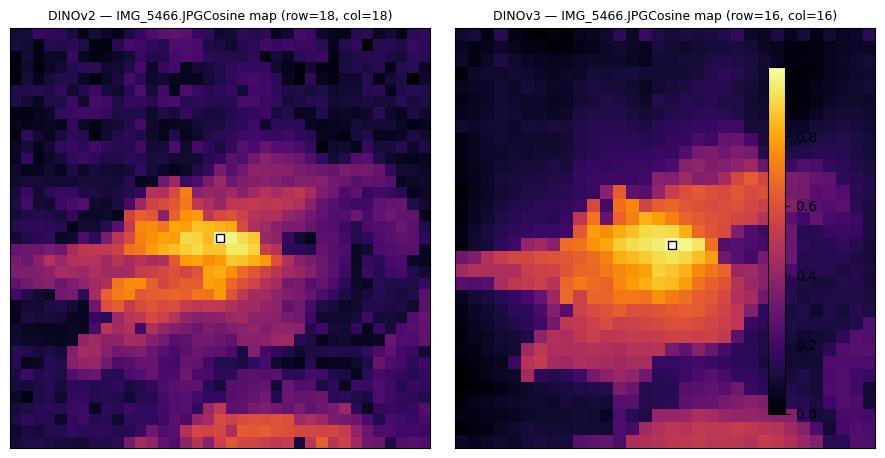

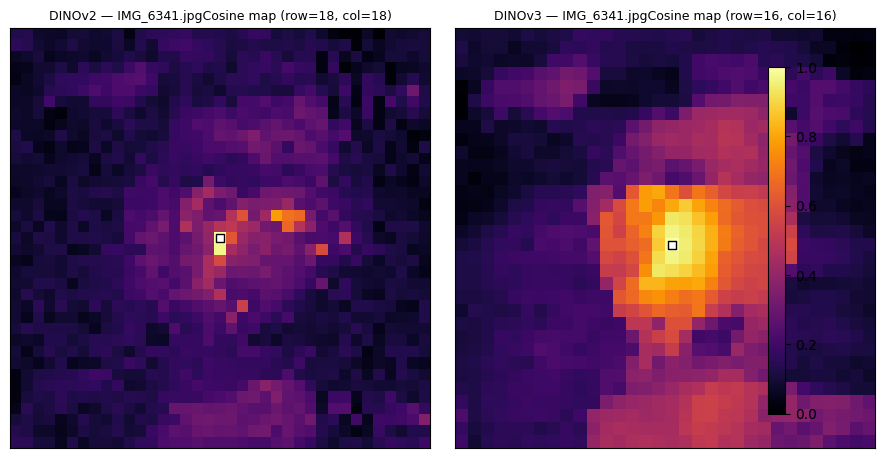

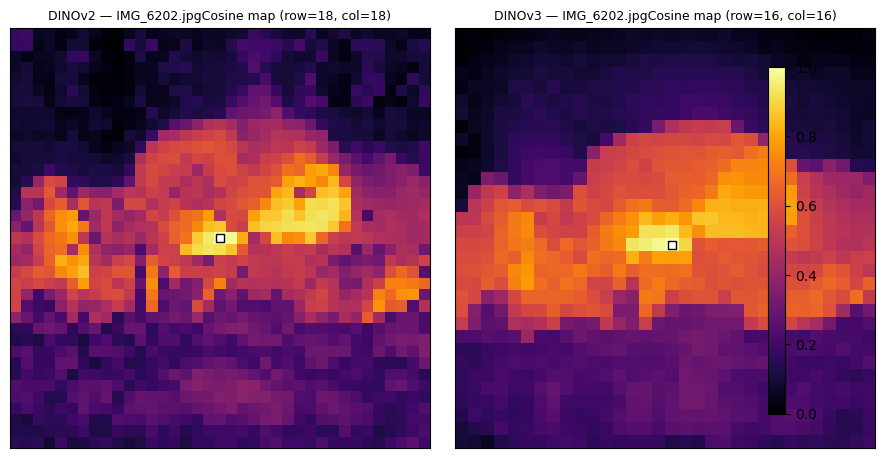

In [11]:
# [STEP] Cosine similarity comparison (DINOv2 vs DINOv3)
# Central patch by default; change `image_idx` or `query_patch` to explore.
plot_cosine_comparison(image_idx=0, query_patch=None)
plot_cosine_comparison(image_idx=3, query_patch=None)
plot_cosine_comparison(image_idx=2, query_patch=None)



## Adanced explanation: Gram Anchoring, a regularization for **dense features** (DINOv3)

**Problem.** In large-scale self-supervised training, **dense (patch) features** can **degrade** over long schedules: global classification gets better, but patch-level maps become **noisy**, hurting segmentation-like tasks.

**Idea.** DINOv3 introduces **Gram Anchoring**: instead of constraining each patch embedding directly, it regularizes the **pairwise similarity structure** between patches via the **Gram matrix**.

- Let $S \in \mathbb{R}^{P \times D}$ be the student patch features for an image (P = number of patches, D = feature dim).
- Define the (normalized) Gram matrix $G_s = \mathrm{norm}(S S^\top)$, which captures **all patch-to-patch cosine relations**.
- A **Gram teacher** $G_t$ is obtained from an **earlier, more stable** checkpoint (e.g., an EMA of the student early in training).
- **Loss:** encourage $G_s \approx G_t$, $ \mathcal{L}_{\text{Gram}} = \| G_s - \mathrm{stopgrad}(G_t) \|_F^2 $ 

**Why this yields smoother PCA maps.** By preserving the **relational structure** between patches (their pairwise cosines), DINOv3 maintains **spatial coherence** in dense features across long training. When you later run PCA over patch embeddings, neighboring patches project to **similar values**, producing **smooth** maps that reflect global geometry rather than local noise.

